In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from __future__ import print_function
import os
import sys
import subprocess

# Download Fashion MNIST
def download_mnist(dirpath):
    if os.path.exists(dirpath):
        print('Found MNIST - skip')
        return
    else:
        os.makedirs(dirpath)
    url_base = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    file_names = ['train-images-idx3-ubyte.gz','train-labels-idx1-ubyte.gz','t10k-images-idx3-ubyte.gz','t10k-labels-idx1-ubyte.gz']
    for file_name in file_names:
        url = (url_base+file_name).format(**locals())
        print(url)
        out_path = os.path.join(dirpath,file_name)
        cmd = ['curl', url, '-o', out_path]
        print('Downloading ', file_name)
        subprocess.call(cmd)

download_mnist('./data/fashion/')

http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/fashion/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/fashion/t10k-images-idx3-ubyte.gz
Extracting ./data/fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


FileNotFoundError: ignored

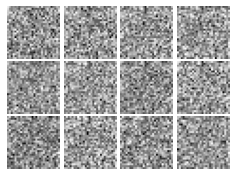

In [3]:
import numpy
import math
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np

# model parameter
noise_dim = 10 # input noise size of Generator
Dhidden = 256  # hidden units of Discriminator's network
Ghidden = 512  # hidden units of Generator's network
K = 8          # maxout units of Discriminator

mini_batch_size = 50
epoch = 50
nsamples = 12 # drawing samples

mnist = input_data.read_data_sets("./data/fashion", one_hot=True)
N, num_features = mnist.train.images.shape
num_labels = 10
period = N // mini_batch_size

X = tf.placeholder(tf.float32, shape=(None, num_features))
Y = tf.placeholder(tf.float32, shape=(None, num_labels))
Z = tf.placeholder(tf.float32, shape=(None, noise_dim))
keep_prob = tf.placeholder(tf.float32)

GW1z = tf.Variable(tf.random_normal([noise_dim, Ghidden], stddev=0.1), name="GW1z")
GW1y = tf.Variable(tf.random_normal([num_labels, Ghidden], stddev=0.1), name="GW1y")
Gb1 = tf.Variable(tf.zeros(Ghidden), name="Gb1")
GW2 = tf.Variable(tf.random_normal([Ghidden, num_features], stddev=0.1), name="GW2")
Gb2 = tf.Variable(tf.zeros(num_features), name="Gb2")

DW1x = tf.Variable(tf.random_normal([num_features, K * Dhidden], stddev=0.01), name="DW1x")
DW1y = tf.Variable(tf.random_normal([num_labels, K * Dhidden], stddev=0.01), name="DW1y")
Db1 = tf.Variable(tf.zeros(K * Dhidden), name="Db1")
DW2 = tf.Variable(tf.random_normal([Dhidden, 1], stddev=0.01), name="DW2")
Db2 = tf.Variable(tf.zeros(1), name="Db2")

def discriminator(x, y):
    u = tf.reshape(tf.matmul(x, DW1x) + tf.matmul(y, DW1y) + Db1, [-1, K, Dhidden])
    Dh1 = tf.nn.dropout(tf.reduce_max(u, reduction_indices=[1]), keep_prob)
    return tf.nn.sigmoid(tf.matmul(Dh1, DW2) + Db2)

def generator(z,y):
    Gh1 = tf.nn.relu(tf.matmul(Z, GW1z) + tf.matmul(Y, GW1y) + Gb1)
    G = tf.nn.sigmoid(tf.matmul(Gh1, GW2) + Gb2)
    return G


G_sample = generator(Z, Y)
DG = discriminator(G_sample, Y)

Dloss = -tf.reduce_mean(tf.log(discriminator(X, Y)) + tf.log(1 - DG))
Gloss = tf.reduce_mean(tf.log(1 - DG) - tf.log(DG + 1e-9)) # the second term for stable learning

vars = tf.trainable_variables()
Dvars = [v for v in vars if v.name.startswith("D")]
Gvars = [v for v in vars if v.name.startswith("G")]

Doptimizer = tf.train.AdamOptimizer().minimize(Dloss, var_list=Dvars)
Goptimizer = tf.train.AdamOptimizer().minimize(Gloss, var_list=Gvars)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(1000000):
    if it % 1000 == 0:
        

        Z_sample = sample_Z(nsamples, noise_dim)
        y_sample = np.zeros(shape=[nsamples, num_labels])
        y_sample[:, 4] = 1 # generating image based on label

        samples = sess.run(G_sample, feed_dict={Z: Z_sample, Y:y_sample})

        fig = plot(samples)
        plt.savefig('output/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    X_mb, y_mb = mnist.train.next_batch(mini_batch_size)

    Z_sample = sample_Z(mini_batch_size, noise_dim)
    _, D_loss_curr = sess.run([Doptimizer, Dloss], feed_dict={X: X_mb, Z: Z_sample, Y:y_mb, keep_prob:0.5})
    _, G_loss_curr = sess.run([Goptimizer, Gloss], feed_dict={Z: Z_sample, Y:y_mb, keep_prob:1.0})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

